In [ ]:
#!pip install -U imbalanced-learn
#!pip install -U scikit-learn

In [ ]:
! pip install pyspark

In [ ]:
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                      NaiveBayes, RandomForestClassifier, GBTClassifier, \
                                      MultilayerPerceptronClassifier, LinearSVC, \
                                      OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
from pyspark.sql import SparkSession
# Initialize Spark session
spark = SparkSession.builder.appName("IntrusionDetection").getOrCreate()

In [ ]:
start = time.time()

In [ ]:
features = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
            "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
            "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
            "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
            "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
            "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
            "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
            "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
            "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [ ]:
dataset = spark.read.csv("/content/corrected", inferSchema=True, header=False)

In [ ]:
dataset = dataset.toDF(*features)

In [ ]:
from pyspark.sql.functions import regexp_replace
dataset = dataset.withColumn("label", regexp_replace("label", "\.", ""))

In [ ]:
print("Dataset sizes: {row} samples, {cols} features".format(row=dataset.count(), cols=len(dataset.columns)))

Dataset sizes: 311029 samples, 42 features


In [ ]:
def find_categorical_columns(df):
    categorical_columns = [col for (col, data_type) in df.dtypes if data_type == "string"]
    return categorical_columns

In [ ]:
# Identify categorical columns in the DataFrame
categorical_columns = find_categorical_columns(dataset)

# Print the result
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['protocol_type', 'service', 'flag', 'label']


In [ ]:
# Check the schema and data
dataset.printSchema()
dataset.show()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [ ]:
categorical_features = ["protocol_type", "service", "flag"]
indexers = [StringIndexer(inputCol=column, outputCol=column + "_num") for column in categorical_features]

In [ ]:
indexers

[StringIndexer_43a6f73904eb,
 StringIndexer_e30cc760d99c,
 StringIndexer_5e2a668117b1]

In [ ]:
indexers.append(StringIndexer(inputCol="label", outputCol="label_num"))
pipeline = Pipeline(stages=indexers)
dataset = pipeline.fit(dataset).transform(dataset)

In [ ]:
dataset.show()

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------------+-----------------+-----------+--------+---------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_ra

In [ ]:
exclude_list = categorical_features + ["label", "label_num"]
# print("Exclude list:")
print(exclude_list)

['protocol_type', 'service', 'flag', 'label', 'label_num']


In [ ]:
numerical_cols = [col for col in dataset.columns if col not in exclude_list]
print(numerical_cols)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_num', 'service_num', 'flag_num']


In [ ]:
df_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
dataset = df_assembler.transform(dataset)
dataset.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [ ]:
from pyspark.sql.functions import col
# List of string columns to drop
string_columns_to_drop = ['protocol_type', 'service', 'flag', 'label']

# Drop the string columns
dataset = dataset.select([col(column) for column in dataset.columns if column not in string_columns_to_drop])

In [ ]:
dataset.show()

+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------------+-----------+--------+---------+--------------------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA
pca = PCA(k=20, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(dataset)
dataset_pca = pca_model.transform(dataset)

In [ ]:
dataset_pca.count()

311029

In [ ]:
# Select the PCA features and label for the final dataset
dataset_pca = dataset_pca.select(["pca_features", "label_num"])

In [ ]:
# Split the dataset into train and test sets
train_set_pca, test_set_pca = dataset_pca.randomSplit([0.90, 0.10], seed=2019)
print("Training set Count: " + str(train_set_pca.count()))
print("Test set Count: " + str(test_set_pca.count()))

Training set Count: 279907
Test set Count: 31122


In [ ]:
# Logistic Regression model
lr2 = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol="pca_features",
                        labelCol="label_num", family="multinomial")

# Decision Tree model
dt2 = DecisionTreeClassifier(labelCol="label_num", featuresCol="pca_features",  maxBins=70)

# Random Forest model
rf2 = RandomForestClassifier(labelCol="label_num", featuresCol="pca_features", numTrees=20, maxBins=70)

# Naive Bayes Multinomial
nb2 = NaiveBayes(labelCol="label_num", featuresCol="pca_features", smoothing=1.0, modelType="multinomial")

# Linear SVM model
lsvc2 = LinearSVC(labelCol="label_num", featuresCol="pca_features", maxIter=10)

# OneVsRest wrapper
ovr2 = OneVsRest(classifier=lsvc2, labelCol="label_num", featuresCol="pca_features")

# Multi Layer Perceptron
multilayer_perceptron2 = MultilayerPerceptronClassifier(labelCol="label_num", featuresCol="pca_features",
                                                       layers=[len(numerical_cols), 10, 5, 38], blockSize=128, seed=1234)

In [ ]:
classifier1 = {"Logistic Regression": lr2, "Decision Tree": dt2,
               "Random Forest": rf2, #"Naive Bayes Multinomial": nb2,
                #"Linear Support Vector Machine": ovr2, "Multilayer Perceptron": multilayer_perceptron2
               }

metric1 = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

In [ ]:
print("\nModels Evaluation:")
print("{:-<30}".format(""))
for c in classifier1:
    print(c)
    # fit the model
    model = classifier1[c].fit(train_set_pca)

    # make predictions
    predictions = model.transform(test_set_pca)
    predictions.cache()

    # evaluate performance
    evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction")

    for m in metric1:
        evaluator.setMetricName(m)
        metric = evaluator.evaluate(predictions)
        print("{name} = {value:.2f}".format(name=m, value=metric))

        print("{:-<30}".format(""))


Models Evaluation:
------------------------------
Logistic Regression
accuracy = 0.63
------------------------------
weightedPrecision = 0.48
------------------------------
weightedRecall = 0.63
------------------------------
f1 = 0.52
------------------------------
Decision Tree
accuracy = 0.94
------------------------------
weightedPrecision = 0.91
------------------------------
weightedRecall = 0.94
------------------------------
f1 = 0.92
------------------------------
Random Forest
accuracy = 0.95
------------------------------
weightedPrecision = 0.92
------------------------------
weightedRecall = 0.95
------------------------------
f1 = 0.93
------------------------------


In [ ]:
from pyspark.ml import Pipeline
# Assuming dt_classifier is your decision tree classifier
classifier_stage = dt2

# Create a pipeline with the classifier as the only stage
pipeline = Pipeline(stages=[classifier_stage])

# Fit the pipeline to the training data
model = pipeline.fit(train_set_pca)

In [ ]:
# SHAP Explanation
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = test_set_pca.toPandas()

In [ ]:
pandas_df

,pca_features,label_num
0,"[-283617.1004075654, -716.4595784332352, 272.3...",8.0
1,"[-283617.1004075654, -716.4595784332352, 272.3...",8.0
2,"[-283617.1004075654, -716.4595784332352, 272.3...",8.0
3,"[-283617.10040016554, -716.4595400781009, 272....",8.0
4,"[-283617.10038537165, -716.4604359781832, 272....",8.0
...,...,...
31117,"[0.007258920706397465, -0.3119473168569515, -2...",2.0
31118,"[0.007258920706397465, -0.3119473168569515, -2...",2.0
31119,"[0.00725893603082971, -0.31194770868243726, -2...",2.0
31120,"[0.0072589360369380304, -0.3119477082393384, -...",2.0


In [ ]:
# Split the 'features_dense' column into multiple columns
import pandas as pd
df_features_split = pd.DataFrame(pandas_df['pca_features'].tolist(), columns=['PCA_' + str(i) for i in range(len(pandas_df['pca_features'].iloc[0]))])

In [ ]:
df_features_split

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
0,-283617.100408,-716.459578,272.393269,34.110300,-0.656753,-2.436735,2.794778,-5.511632,-0.126310,-0.047607,-0.375276,-0.342861,-0.276977,-0.642163,-0.885725,0.424653,-0.087886,0.314042,-0.363471,-0.784677
1,-283617.100408,-716.459578,272.393269,34.110300,-0.656753,-2.436735,2.794778,-5.511632,-0.126310,-0.047607,-0.375276,-0.342861,-0.276977,-0.642163,-0.885725,0.424653,-0.087886,0.314042,-0.363471,-0.784677
2,-283617.100408,-716.459578,272.393269,34.110300,-0.656753,-2.436735,2.794778,-5.511632,-0.126310,-0.047607,-0.375276,-0.342861,-0.276977,-0.642163,-0.885725,0.424653,-0.087886,0.314042,-0.363471,-0.784677
3,-283617.100400,-716.459540,272.378663,34.249796,-1.514065,-2.632369,3.249575,-5.519755,-0.125846,-0.046858,-0.366757,-0.344451,-0.281639,-0.654823,-0.891766,0.429885,-0.089494,0.319472,-0.386056,-0.766510
4,-283617.100385,-716.460436,272.379152,34.304574,-0.141163,-5.364458,2.439337,-5.532233,-0.124626,-0.037328,-0.722616,-0.231301,-0.158251,-0.345742,-0.702081,0.347453,-0.060570,0.138515,-0.051476,-0.098506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31117,0.007259,-0.311947,-23.441441,231.660476,149.169176,-237.940027,150.779289,-2.827821,0.240026,2.590091,-0.874299,0.519738,0.392909,0.119912,-0.419983,0.181722,-0.012540,-0.000710,-0.353159,-0.562087
31118,0.007259,-0.311947,-23.441441,231.660476,149.169176,-237.940027,150.779289,-2.827821,0.240026,2.590091,-0.874299,0.519738,0.392909,0.119912,-0.419983,0.181722,-0.012540,-0.000710,-0.353159,-0.562087
31119,0.007259,-0.311948,-23.441557,231.660414,149.170772,-237.940016,150.788039,-2.820079,0.241804,-0.389767,-0.878596,0.855986,0.451041,0.067249,-0.430643,0.183994,-0.011730,0.013789,-0.345563,-0.558545
31120,0.007259,-0.311948,-23.441557,231.660415,149.170768,-237.940016,150.788030,-2.820060,0.241804,-0.389794,-0.878580,0.856211,0.451034,0.067394,-0.428075,0.182547,-0.011461,0.014807,-0.350242,-0.560347


In [ ]:
# Concatenate the new columns with the original DataFrame
pandas_df = pd.concat([pandas_df, df_features_split], axis=1)

# Drop the original 'features_dense' column
pandas_df = pandas_df.drop(['pca_features', 'label_num'], axis=1)

In [ ]:
# Assuming pandas_df is your DataFrame
column_names = pandas_df.columns

In [ ]:
! pip install shap

In [ ]:
# Get feature importances
feature_importances = model.stages[0].featureImportances

# Display feature importances
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"{column_names[i]}: {importance}")

Feature Importances:
PCA_0: 0.31826781003888016
PCA_1: 0.6097731005748636
PCA_2: 0.012862193460014309
PCA_3: 0.002794008543549185
PCA_4: 0.002055985466320074
PCA_5: 0.0006179344584020581
PCA_6: 0.0
PCA_7: 0.0014034804351628698
PCA_8: 0.003027408592079985
PCA_9: 0.00024391853283544848
PCA_10: 0.021012393540670356
PCA_11: 0.0
PCA_12: 0.01253155292587937
PCA_13: 0.0
PCA_14: 0.0
PCA_15: 6.283617579039912e-05
PCA_16: 1.6757615340306076e-05
PCA_17: 0.0
PCA_18: 0.0
PCA_19: 0.01533061964021206


In [ ]:
import shap
# Explain the model using SHAP
explainer = shap.TreeExplainer(model.stages[0])

In [ ]:
shap_values = explainer.shap_values(pandas_df, check_additivity=False)

In [ ]:
import numpy as np
# Summarize the feature importance
feature_importance = np.abs(shap_values).mean(axis=0)
print("Feature Importance:", feature_importance)

Feature Importance: [[0.02498453 0.02037236 0.0396248  ... 0.         0.         0.00011391]
 [0.02498453 0.02037236 0.0396248  ... 0.         0.         0.00011391]
 [0.02498453 0.02037236 0.0396248  ... 0.         0.         0.00011391]
 ...
 [0.02240805 0.02796864 0.0001507  ... 0.         0.         0.00104117]
 [0.02240805 0.02796864 0.0001507  ... 0.         0.         0.00104117]
 [0.02240805 0.02796864 0.0001507  ... 0.         0.         0.00104117]]


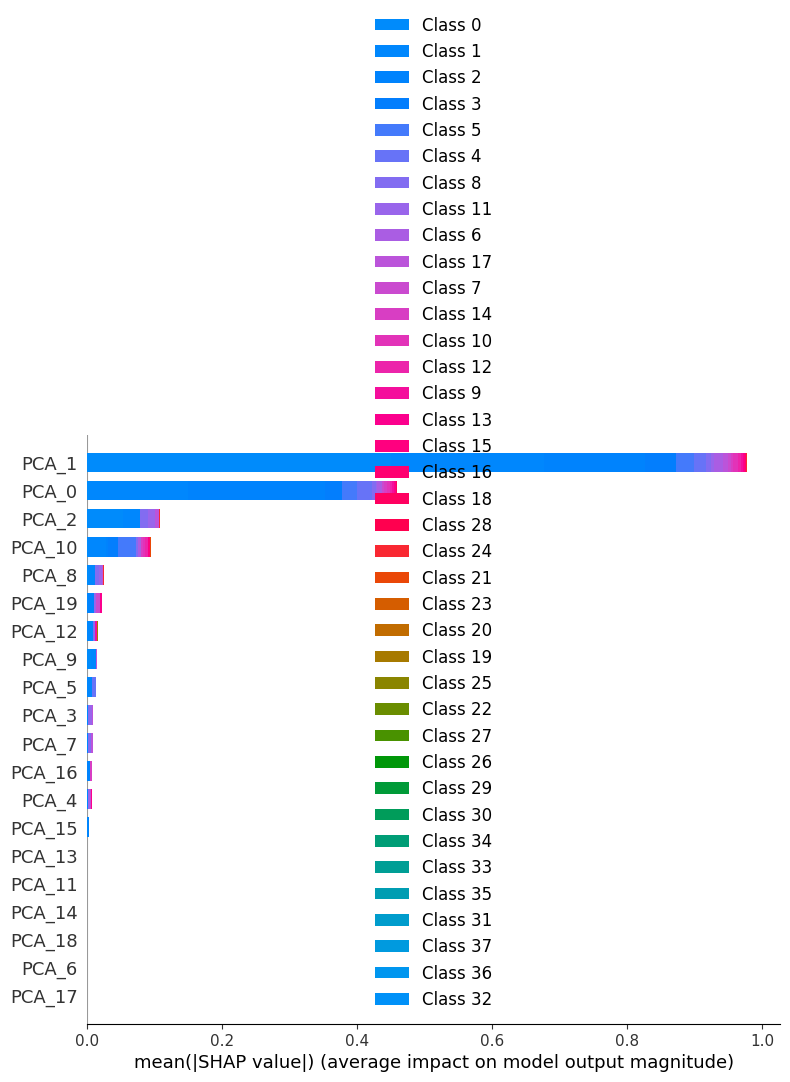

In [ ]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, pandas_df, feature_names=column_names)

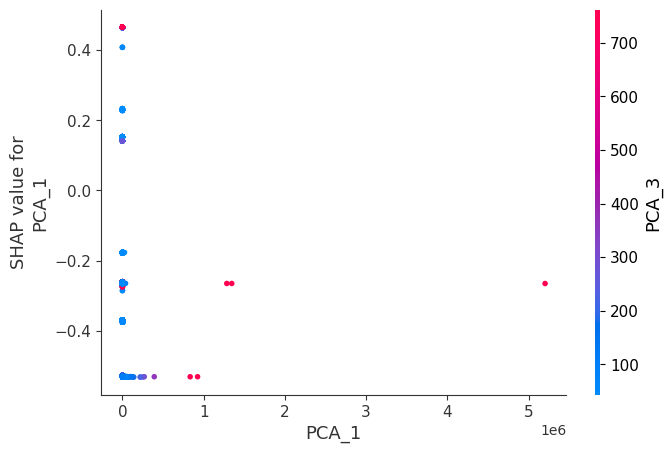

In [ ]:
# SHAP dependence plot for a specific feature
feature_of_interest = 'PCA_1'
shap.dependence_plot(feature_of_interest, shap_values[0], pandas_df, feature_names=column_names)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Define hyperparameter grids for each model
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr2.maxIter, [10, 20])
                .addGrid(lr2.regParam, [0.1, 0.3])
                .addGrid(lr2.elasticNetParam, [0.2, 0.8])
                .build())

paramGrid_dt = (ParamGridBuilder()
                .addGrid(dt2.maxDepth, [5, 10])
                .addGrid(dt2.maxBins, [66, 70])
                .build())

paramGrid_rf = (ParamGridBuilder()
                .addGrid(rf2.numTrees, [10, 20])
                .addGrid(rf2.maxDepth, [5, 10])
                .addGrid(rf2.maxBins, [65, 70])
                .build())

paramGrid_nb = (ParamGridBuilder()
                .addGrid(nb2.smoothing, [0.5, 1.5])
                .build())

# Define hyperparameter grid for OneVsRest
paramGrid_lsvc = (ParamGridBuilder()
                 .addGrid(lsvc2.maxIter, [5, 10])
                 .build())

# OneVsRest wrapper
paramGrid_ovr = OneVsRest(classifier=paramGrid_lsvc, labelCol="label_num", featuresCol="pca_features")

paramGrid_mlp = (ParamGridBuilder()
                 .addGrid(multilayer_perceptron2.layers, [[len(numerical_cols), 10, 5, 38], [len(numerical_cols), 15, 10, 38]])
                 .addGrid(multilayer_perceptron2.blockSize, [128, 256])
                 .build())

# Create parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(lsvc2.regParam, [0.01, 0.1, 1.0]) \
    .build()

In [ ]:
# Dictionary of models and their respective hyperparameter grids
models_and_params = {"Logistic Regression": (lr2, paramGrid_lr),
                    "Decision Tree": (dt2, paramGrid_dt),
                    # "Naive Bayes": (nb2, paramGrid_nb),
                     "Random Forest": (rf2,paramGrid_rf),
                     #"Linear SVM": (ovr, param_grid),  # Using OneVsRest for Linear SVM
                     #"Multilayer Perceptron": (multilayer_perceptron2, paramGrid_mlp)
                    }

In [ ]:
metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

In [ ]:
# Perform hyperparameter tuning using GridSearchCV
print("\nModels Evaluation with Hyperparameter Tuning:")
print("{:-<45}".format(""))
for model_name, (model, paramGrid) in models_and_params.items():
    print(model_name)

    # Create CrossValidator
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction"),
                              numFolds=3)  # You can adjust the number of folds

    # Fit the model
    best_model = crossval.fit(train_set_pca)

    # Make predictions
    predictions = best_model.transform(test_set_pca)
    predictions.cache()

    # Evaluate performance
    evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction")

    for m in metrics:
        evaluator.setMetricName(m)
        metric = evaluator.evaluate(predictions)
        print("{name} = {value:.2f}".format(name=m, value=metric))

    print("{:-<45}".format(""))


Models Evaluation with Hyperparameter Tuning:
---------------------------------------------
Logistic Regression
accuracy = 0.90
weightedPrecision = 0.83
weightedRecall = 0.90
f1 = 0.86
---------------------------------------------
Decision Tree
accuracy = 0.98
weightedPrecision = 0.97
weightedRecall = 0.98
f1 = 0.97
---------------------------------------------
Random Forest
accuracy = 0.98
weightedPrecision = 0.98
weightedRecall = 0.98
f1 = 0.98
---------------------------------------------
